## <span style="color:#008891">Description of survey results: temporal, geopgraphic and administrative scope</span>

#### <span style="color:#008891">Identification, quantification and analysis of observable anthropogenic debris along swiss river and lakes</span>

The summary of the survey results and survey characteristics is provided. The results are presented nationally and by river bassin for all surveys since April 1, 2020.  For now this function only works on data later than January 1st 2020. We are in the process of integrating the data from prior projects.

#### <span style="color:#008891">Contents</span>

1. [A summary](#scope) of the number of locations and the effected population as well as an exhaustive list of lakes, rivers and municipalites where surveys were conducted.

2. [The dimensional records](#validdata) are matched to the survey records, missing records are identified and records that do not have a match in both data sets are excluded. The list of excluded surveys and the percentage of all the surveys that are being used to calculate the summary is provided.

3. [The dimensional summary](#datasummary) records are summarized to the river bassin.

4. [Figure 1](#figureone): relationship of "number of items found per survey" to the measured variables, grouped by river bassin


#### <span style="color:#008891">More information </span>

For information on a specific catchment area or a water feature see the notebook for that catchment area (or make one and send a pull request). For more information on the project visit https://www.plagespropres.ch/ .

In [1]:
# sys, file and nav packages:
import os
import datetime as dt
import csv
import json

# math packages:
import pandas as pd
import numpy as np
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import base64, io, IPython
from PIL import Image as PILImage

# home brew utitilties
import utilities.utility_functions as ut
import utilities.abundance_classes as ac

# # chart kwargs
# title_k = {'loc':'left', 'pad':14, 'linespacing':1.5, 'fontsize':12}
title_k14 = {'loc':'left', 'pad':16, 'linespacing':1.5, 'fontsize':14}
# xlab_k = {'labelpad':10, 'fontsize':12}
xlab_k14 = {'labelpad':14, 'fontsize':14}

# easy variables to the directory tree
most_recent, survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

today = dt.datetime.now().date().strftime("%Y-%m-%d")

# set some parameters:
start_date = '2020-04-01'
end_date =today

# name the folder:
name_of_project = 'project_scope'

# use this to store things:
project_directory = ut.make_project_folder(output, name_of_project)

# keep track of output
files_generated = []
figure_num = 0
data_num = 0

# kwargs for the abundance class
group_names_locations = ut.json_file_get(F"{output}/code_groups/code_group2.json")

# convenience method to organize output
def add_output(**kwargs):
    files_generated.append({'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']})
    if kwargs['a_type'] == 'data':
        kwargs['data'].to_csv(F"{kwargs['file']}.csv", index=False)
    else:
        plt.savefig(F"{kwargs['file']}.jpeg", dpi=300)


data_sources = {    
    "survey_data":"results_with_zeroes.csv",
    "river_bassins":"river_basins.json",
    "beaches":"beaches_with_gis.csv",
    "codes":"mlw_codes.csv",
    "code_groups":"code_group2.json",
    "dims_data":"dims_data.csv"
}

# define the methods to use for the .JSON and .csv files:
my_data_methods = {'json':ut.json_file_get, 'csv':pd.read_csv}

# get your data:
survey_data, river_bassins, dfBeaches, dfCodes, code_groups, dfDims = ac.get_data_from_most_recent(data_sources, data_methods=my_data_methods)

# format the date to timestamp and slice the data by start/end date
dfSurveys = ac.fo_rmat_and_slice_date(survey_data.copy(), a_format="%Y-%m-%d", start_date=start_date, end_date=end_date)

# add the grouping column defined by river_bassins
data = ac.add_a_grouping_column(dfSurveys, river_bassins, column_to_match="water_name_slug")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# set the index of dfCodes to code:
dfCodes.set_index('code', inplace=True)

# assign river bassin labels to locations:
for k,v in river_bassins.items():
    dfBeaches.loc[dfBeaches.water_name_slug.isin(v), 'river_bassin'] = k


# code definitions
# dfCodes = pd.read_csv(F"{code_defs}/mlw_codes.csv", index_col='code')

# dimensional data
# the loc date key needs updating:
dfDims['loc_date'] = list(zip(dfDims.location, dfDims.date))

# project lakes and beaches:
# project_lakes = ut.json_file_get(F"{location_data}/project_lakes.json")
# project_beaches = ut.json_file_get(F"{location_data}/project_beaches.json")

# make a copy of the survey data and tag the records as either lake or river:
data = dfSurveys.copy()

# columns can be added to the data before prcessing it

# map lake or river from dfBeaches
lakes = dfBeaches[dfBeaches.water == 'l'].water_name_slug.unique()
rivers = dfBeaches[dfBeaches.water == 'r'].water_name_slug.unique()

# tagging each record as either lake or river:
# map values to new column t:
data['type'] = 't'
for a_place in data.water_name_slug.unique():
    data.loc[data.water_name_slug.isin(lakes), 'type'] = 'l'
    data.loc[data.water_name_slug.isin(rivers), 'type'] = 'r'

# check if there are any un categorized records:
if len(data[data['type']=='t']) > 0:
    print(F"\nThere are {len(data[data['type']=='t'])} records that were not classified as either lake or river:\n\n{data[data['type']=='t']}\n")
else:
    pass

# put the data into a class
# kwargs for the data class
a_class_kwargs = dict(
    code_group_data=group_names_locations,
    levels=['river_bassin', 'water_name_slug', 'city'],
    river_bassins=river_bassins,
    exp_variables=['population','buildings', 'streets', 'intersects'],
    code_group_loc=output,
)

# this puts the data into an abundance class
a = ac.PreprocessData(data, dfBeaches,**a_class_kwargs)

# define the final data set here:
a_data = a.survey_data.copy()

n_samps_rivers_lakes = a_data[['loc_date', 'type']].groupby('type').nunique()

# locations included in this report, export to GIS for mapping
geo_df = dfBeaches.loc[a_data.location.unique()]
filename = F"{project_directory}/report_locations.csv"
geo_df.to_csv(filename, index=False)

# describe the data set:
num_obs = len(a_data)
num_samps = len(a_data.loc_date.unique())
num_obj = a_data.quantity.sum()
num_locs = len(a_data.location.unique())
num_rivs = a_data[a_data['type']=='r'].water_name_slug.nunique()
num_lakes = a_data[a_data['type'] == 'l'].water_name_slug.nunique()

# number of municipalities
a_map = dfBeaches['city']
munis = [a_map[x] for x in a_data.location.unique()]
munis = sorted(list(set(munis)))
num_munis = len(munis)

# population
total_pop_d = dfBeaches.loc[a_data.location.unique()][['city', 'population']]
total_pop_c = total_pop_d.drop_duplicates('city')
total_pop = total_pop_c.population.sum()

<a id='scope'></a>
#### <span style="color:#008891"> Effective dates, river bassins, number of obervations, number of surveys and number of objects</span>

In [2]:
print(F"\nThis data is valid for surveys between {start_date} and {end_date} from the following catchment areas:\n\n  {a_data.river_bassin.unique()}")

print(F"\nThere are {'{:,}'.format(num_obs)} observations from {num_samps} surveys.\n\nThere were {'{:,}'.format(num_obj)} objects collected.")


This data is valid for surveys between 2020-04-01 and 2021-04-29 from the following catchment areas:

  ['linth' 'aare' 'reuss' 'rhone' 'ticino']

There are 79,781 observations from 361 surveys.

There were 51,165 objects collected.


In [3]:
print(F"\nThere are {num_locs} different survey locations from {num_munis} municipalities with a total population of ~{'{:,}'.format(total_pop)}")
print(F"\nThere are {n_samps_rivers_lakes.loc['l'][0]} samples from {num_lakes} different lakes and {n_samps_rivers_lakes.loc['r'][0]} samples from {num_rivs} different rivers.\n")

print(F"\nThe lakes where the surveys were conducted:\n\n{sorted(a_data[a_data['type'] == 'l'].water_name_slug.unique())}\n")

print(F"\nThe rivers where the surveys were conducted:\n\n{sorted(a_data[a_data['type'] == 'r'].water_name_slug.unique())}\n")

print(F"\nThe municpalities where the surveys were conducted:\n\n{sorted(munis)}\n")


There are 130 different survey locations from 74 municipalities with a total population of ~1,669,684

There are 312 samples from 10 different lakes and 49 samples from 16 different rivers.


The lakes where the surveys were conducted:

['bielersee', 'brienzersee', 'lac-leman', 'lago-maggiore', 'neuenburgersee', 'quatre-cantons', 'thunersee', 'walensee', 'zugersee', 'zurichsee']


The rivers where the surveys were conducted:

['aare', 'aarenidau-buren-kanal', 'dorfbach', 'emme', 'escherkanal', 'jona', 'la-thiele', 'limmat', 'linthkanal', 'maggia', 'reuss', 'rhone', 'schuss', 'seez', 'sihl', 'ticino']


The municpalities where the surveys were conducted:

['Aarau', 'Allaman', 'Ascona', 'Beatenberg', 'Bellinzona', 'Bern', 'Biel/Bienne', 'Boudry', 'Bourg-en-Lavaux', 'Brienz (BE)', 'Brugg', 'Brügg', 'Burgdorf', 'Bönigen', 'Cheyres-Châbles', 'Cudrefin', 'Dietikon', 'Estavayer', 'Freienbach', 'Gals', 'Gambarogno', 'Gebenstorf', 'Genève', 'Gland', 'Glarus Nord', 'Grandson', 'Hauterive (NE)',

<a id='validdata'></a>
## <span style="color:#008891">The dimensional data summary</span>

### <span style="color:#008891"> Match the dimensional records to the survey records</span>

#### There are two components to a survey:

1. The objects that are found
2. The context in which they were found -- dimensional data

These two elements are transmitted seperately when the surveyor submits the data. The main reason for this is efficiency and speed. The context for each survey is unique and each survey can generate up to 220 observations with the same context.

Before analysis the dimensional data records need to be matched up to the survey data. The *loc_date* key is the unique indentifier for each survey. Here we match up the loc_date keys from both data sets.

Dimensional data with no matching survey is dropped. An inquiry is made to the surveyor to identify the nature of the discrepancy. Missing dimensional data can be recuperated by asking the surveyor. There are paper records generated at each survey. Records are dropped from the server or ammended once the surveyor has replied to the inquiry.

In [4]:
# gather the dimensional data for the time frame
som_dims = dfDims[(dfDims.date >= start_date)&(dfDims.date <= end_date)].copy()

# map survey total to loc date from the survey data
some_q = a.daily_totals_all[['loc_date', 'quantity']].set_index('loc_date')

# use only data from the surveys in a_data:
som_dims = som_dims[som_dims.loc_date.isin(a_data.loc_date.unique())].copy()

# keep the dims that don't match
no_matching_locdate = som_dims[~som_dims.loc_date.isin(a_data.loc_date.unique())]

# get a list of unique loc_date values from each set
ldu = a_data.loc_date.unique()
ddu = som_dims.loc_date.unique()

# identify the surveys with no matching dimensional data
no_dim_locdate = [x for x in list(ldu) if x not in list(ddu)]

# map quantity per survey to the dims data
som_dims['quantity'] = som_dims.loc_date.map(lambda x: ut.use_this_key(x,some_q, column='quantity'))

# keep the dims that did not get tagged with a qty
no_qty = som_dims[som_dims.quantity == 'no data'][['location', 'date']].copy()

# drop the dims that did not match
som_dims = som_dims[som_dims.quantity != 'no data'].copy()

# map locations to feature names
location_wname_key = dfBeaches.water_name_slug

# assign a water feature name to each record
som_dims['water_name_slug'] = som_dims.location.map(lambda x: location_wname_key.loc[x])

# assign a river bassin name to each record
for k,v in river_bassins.items():
    som_dims.loc[som_dims.water_name_slug.isin(v), 'river_bassin'] = k

# map the number of samples per water feature or bassin:
samples_feature = a_data.groupby('water_name_slug').loc_date.nunique()
samples_bassin = a_data.groupby('river_bassin').loc_date.nunique()

# map total quantity per river bassin:
qty_bassin = a_data.groupby('river_bassin').quantity.sum()
qty_feature = a_data.groupby('water_name_slug').quantity.sum()

# 120 minutes covers the travel, equipment preparation and maintenance and incidental time on location:
som_dims['total_time'] = som_dims.time_minutes+120
som_dims['total_time'] = som_dims.total_time/60
som_dims['total_time'] = som_dims.total_time.round(2)


print(F"\nThese are the dimensional records that do not have a matching survey in the survey data:\n\n{no_qty}\n")
if len(no_qty) > 0:
    print(F"\nThe dims records with no matching survey records have been dropped.\n")
else:
    print("All dimensional records found a home in the survey data!")
    
print(F"\nThese are the surveys that do not have matching dimensional data:\n\n{no_dim_locdate}\n")

if len(no_dim_locdate) > 0:
    print(F"\nThe dimensional data for the surveys with no matching dimensional records are not included in the survey dimensions summary.")
    print(F"\n!In other terms THE DIMENSIONAL DATA IS CALCULATED USING {np.round(((1-len(no_dim_locdate)/len(ldu))*100),1)}% of the survey data.")
    print("\nRequests have been made to surveyors to submit the missing records. The dimensional data is initially recorded in the surveyors notebook.\n")
else:
    print("\nAll the surveys found a home in the dimensional data")


These are the dimensional records that do not have a matching survey in the survey data:

Empty DataFrame
Columns: [location, date]
Index: []

All dimensional records found a home in the survey data!

These are the surveys that do not have matching dimensional data:

[('baby-plage-geneva', '2021-04-14'), ('quai-maria-belgia', '2021-02-28'), ('quai-maria-belgia', '2021-01-31')]


The dimensional data for the surveys with no matching dimensional records are not included in the survey dimensions summary.

!In other terms THE DIMENSIONAL DATA IS CALCULATED USING 99.2% of the survey data.

Requests have been made to surveyors to submit the missing records. The dimensional data is initially recorded in the surveyors notebook.




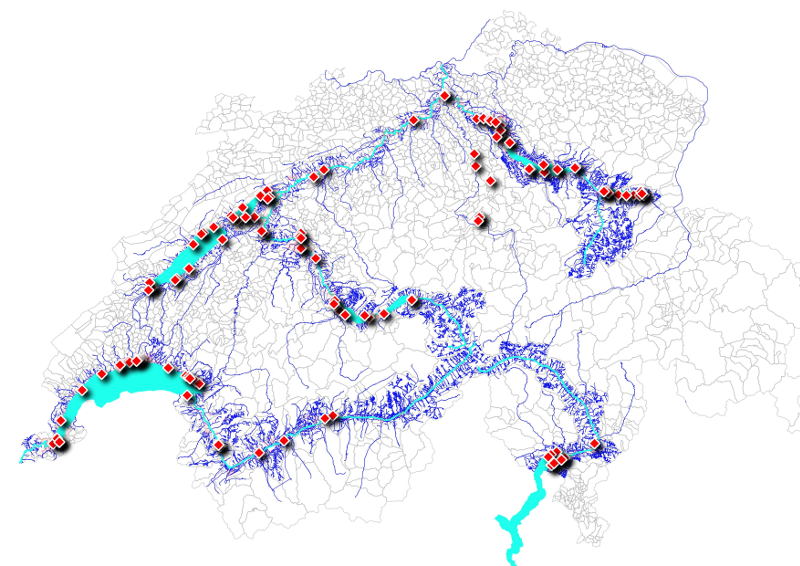

In [5]:
image = PILImage.open("resources/maps/national.png")

output = io.BytesIO()
image.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

<a id='datasummary'></a>
### <span style="color:#008891">The dimensional records</span>

The following information is recorded at each survey:

1. Length of survey area
2. Surface area
3. Weight of all objects
4. Weight of all plastics
5. Weight of all plastics < 5mm
6. Time to complete a survey
7. Number of participants
8. Participating groups

For objects that are greater than 5mm the weights are recorded on location. The smaller objects are weighed on a more appropriate scale. The length and the surface area are recorded at each survey.

#### <span style="color:#008891">Cumulative totals all data</span>

In [6]:


new_cols = {
    'total_time':'time to survey',
    'length':'meters surveyed',
    'area':'m² surveyed',
    'total_w':'total weight',
    'mac_plast_w':'plastic > 5mm weight',
    'mic_plas_w':'plastic < 5mm weight',
    'num_parts_staff':'staff',
    'num_parts_other':'help',
    'participants':'groups'
}

som_dims.rename(columns=new_cols, inplace=True)

In [7]:
# group by river bassin
agg_this = {
    'time to survey':'sum',
    'meters surveyed':'sum',
    'm² surveyed':'sum',
    'total weight':'sum',
    'plastic > 5mm weight':'sum',
    'plastic < 5mm weight':'sum',
    'staff':'sum',
    'help':'sum',
    'loc_date':'nunique'}
dims_summary_stats = som_dims.groupby('river_bassin').agg(agg_this)
dims_summary_stats.rename(columns={'loc_date':'# samples'}, inplace=True)

# convert the plastic weights to kilos
dims_summary_stats['plastic > 5mm weight'] = dims_summary_stats['plastic > 5mm weight']/1000
dims_summary_stats['plastic < 5mm weight'] = dims_summary_stats['plastic < 5mm weight']/1000

# get the quantity found per river bassin
dims_summary_stats['quantity'] = dims_summary_stats.index.map(lambda x: ut.use_this_key(x, qty_bassin))

som_cols = [
    'time to survey',
    'meters surveyed',
    'm² surveyed',
    'total weight',
    'plastic > 5mm weight',
    'staff', 'help',
    '# samples',
    'quantity'
]
ints = som_cols = [
    'time to survey',
    'meters surveyed',
    'm² surveyed',
    'total weight',
    'staff', 'help',
    '# samples',
    'quantity'
]
def make_series_an_int(x):
    return x.astype('int')
col_order = ['# samples',  'meters surveyed', 'm² surveyed', 'total weight', 'plastic > 5mm weight','plastic < 5mm weight', 'quantity', 'time to survey', 'help', 'staff']

# reorder the columns
dims_summary_stats[som_cols] = dims_summary_stats[som_cols].apply(lambda x: x.astype('int'))
dims_summary_stats = dims_summary_stats[col_order]

# make a summary of all data
asum = pd.DataFrame(dims_summary_stats.sum()).round(2)
asum.reset_index(inplace=True)

# pandas gymnastics os that inst are displayed as ints:
asum['summary total'] = 'summary total'
asum['# samples'] = len(som_dims)
asum = asum.pivot(columns='index', values=0, index='summary total')
asum[ints] = asum[ints].apply(lambda x: x.astype('int'))
asum = asum[col_order]

print(F"\nThe cumulative results from {len(som_dims.loc_date.unique())} samples, weights are in kilograms, time is in hours\n\n")
asum


The cumulative results from 358 samples, weights are in kilograms, time is in hours




index,# samples,meters surveyed,m² surveyed,total weight,plastic > 5mm weight,plastic < 5mm weight,quantity,time to survey,help,staff
summary total,,,,,,,,,,
summary total,358,18547,90007,280,87.15,0.22,51165,1400,130,369


<br></br>
#### <span style="color:#008891">Cumulative totals by river basin</span>

In [8]:
print("\n\nThe cumulative results for each river basin, weights are in kilograms, time is in hours:\n\n")
dims_summary_stats



The cumulative results for each river basin, weights are in kilograms, time is in hours:




,# samples,meters surveyed,m² surveyed,total weight,plastic > 5mm weight,plastic < 5mm weight,quantity,time to survey,help,staff
river_bassin,,,,,,,,,,
aare,135,7645,35579,70,31.161170,0.167320,13511,541,6,137
linth,100,4912,23678,32,12.106621,0.004179,8814,367,7,103
reuss,8,225,832,1,0.301000,0.000000,123,21,2,8
rhone,98,4710,24930,144,41.757375,0.049155,27287,407,115,104
ticino,17,1055,4988,33,1.825180,0.000249,1430,64,0,17


<a id='figureone'></a>
<br></br>
#### <span style="color:#008891">The number of objects indentified versus time to survey, length, weights, surface area</span>

In [9]:
greater_than_50 = som_dims[som_dims['total weight'] >= 50]['loc_date'].unique()
greater_than_ten = som_dims[som_dims['plastic < 5mm weight'] >= 10]['loc_date'].unique()

In [10]:
print(F"\nThe following Surveys are not included in the charts below:\n")

print(F"Surveys with a total weight greater than 50kg:\n\n  {greater_than_50}\n")

print(F"Surveys with a micro plastic weight greater than 10g:\n\n  {greater_than_ten}\n")


The following Surveys are not included in the charts below:

Surveys with a total weight greater than 50kg:

  [('lavey-les-bains-2', '2021-02-24')]

Surveys with a micro plastic weight greater than 10g:

  [('baby-plage-geneva', '2020-07-07') ('wycheley', '2020-11-07')]



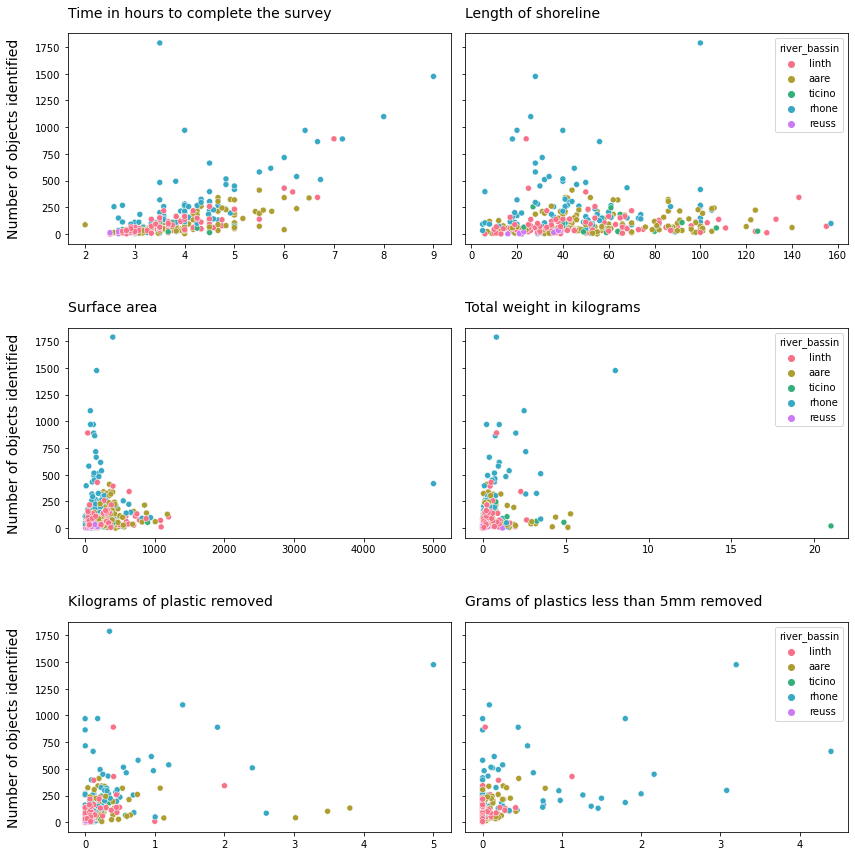

In [11]:
print("\n")
fig, axs = plt.subplots(3,2,figsize=(12,12), sharex=False, sharey=True)
sns.scatterplot(data=som_dims, x='time to survey', y='quantity', hue='river_bassin', palette='husl', ax=axs[0,0])
axs[0,0].get_legend().remove()
axs[0,0].set_title("Time in hours to complete the survey", **title_k14 )
axs[0,0].set_xlabel("")
axs[0,0].set_ylabel("Number of objects identified", **xlab_k14)


sns.scatterplot(data=som_dims, x='meters surveyed', y='quantity', hue='river_bassin', palette='husl', ax=axs[0,1])
axs[0,1].set_title("Length of shoreline", **title_k14 )
axs[0,1].set_xlabel("")
axs[0,1].set_ylabel("Number of objects identified", **xlab_k14)


sns.scatterplot(data=som_dims, x='m² surveyed', y='quantity', hue='river_bassin', palette='husl', ax=axs[1,0])
axs[1,0].get_legend().remove()
axs[1,0].set_title("Surface area", **title_k14 )
axs[1,0].set_xlabel("")
axs[1,0].set_ylabel("Number of objects identified", **xlab_k14)

sns.scatterplot(data=som_dims[som_dims['total weight'] < 50], x='total weight', y='quantity', hue='river_bassin', palette='husl', ax=axs[1,1])
axs[1,1].set_title("Total weight in kilograms", **title_k14 )
axs[1,1].set_xlabel("" )
axs[1,1].set_ylabel("Number of objects identified", **xlab_k14)

sns.scatterplot(data=som_dims[som_dims['total weight'] < 50], x=som_dims[som_dims['total weight'] < 50]['plastic > 5mm weight']/1000, y='quantity', hue='river_bassin', palette='husl', ax=axs[2,0])
axs[2,0].get_legend().remove()
axs[2,0].set_title("Kilograms of plastic removed", **title_k14 )
axs[2,0].set_xlabel("" )
axs[2,0].set_ylabel("Number of objects identified", **xlab_k14)


sns.scatterplot(data=som_dims[som_dims['plastic < 5mm weight'] < 10], x=som_dims[som_dims['plastic < 5mm weight'] < 10]['plastic < 5mm weight'], y='quantity', hue='river_bassin', palette='husl', ax=axs[2,1])
axs[2,1].set_title("Grams of plastics less than 5mm removed", **title_k14 )
axs[2,1].set_xlabel("")
axs[2,1].set_ylabel("Number of objects identified", **xlab_k14)

plt.subplots_adjust(hspace=.5)

plt.tight_layout()
plt.subplots_adjust(hspace=.4)
plt.show()

#### Have a great day

This project was made possible by the Swiss federal office for the environment.

This document originates from https://github.com/hammerdirt-analyst/iqals all copyrights apply.

In [12]:
author = "roger@hammerdirt.ch"
my_message = "Statistics is fun when you do it outside"
print(F"\nProduced by: {author}\nDate: {today}\n\n{my_message}")


Produced by: roger@hammerdirt.ch
Date: 2021-04-29

Statistics is fun when you do it outside
